In [58]:
%load_ext autoreload
%autoreload 2

import os
import time

import numpy as np

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import DataLoader
from torchvision import transforms


from datasets import BadNetsDataset, WaNetDataset
from simclr import SimClrBackbone

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
device = "cuda"
epochs = 1000
batch_size = 128

## Poison dataset

In [60]:
dataset = torchvision.datasets.CIFAR10(root='C:/Datasets', train=True, download=True)
#poison_dataset = BadNetsDataset(dataset, 0, "triggers/trigger_white.png", seed=1, transform=transforms.ToTensor())
poison_dataset = WaNetDataset(dataset, 0, seed=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [76]:
poisoned_index = poison_dataset.poi_indices[0]
noise_index = poison_dataset.noise_indices[1]

index = poisoned_index

img = poison_dataset[index][0].squeeze(0).cpu()

topil = torchvision.transforms.ToPILImage()
out = topil(img)
#out.show()

img = dataset[index][0]
#img.show()




## SimCLR data augmentations

In [62]:
class ConstrastiveDataset(VisionDataset):

    def __init__(self, original_dataset: VisionDataset, s: int = 0.5):
        self.original_dataset = original_dataset

        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomResizedCrop(32,(0.8,1.0),antialias=False),
            transforms.Compose([transforms.RandomApply([
                transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)], p = 0.8),
                transforms.RandomGrayscale(p=0.2)]),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
            ])
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, index):
        img = self.original_dataset[index][0]
        augmented_img_1 = self.transforms(img)
        augmented_img_2 = self.transforms(img)
        return augmented_img_1, augmented_img_2
    
constrastive_dataset = ConstrastiveDataset(poison_dataset)

## SimCLR model

In [63]:
model = SimClrBackbone()
model = model.to(device)

c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## LARS optimizer

In [64]:
from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True

## SimCLR contrastive loss

In [65]:
class SimCLR_Loss(nn.Module):
    def __init__(self, temperature):
        super(SimCLR_Loss, self).__init__()
        self.temperature = temperature

        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
            
        return mask

    def forward(self, z_i, z_j):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
        batch_size = z_i.shape[0]
        mask = self.mask_correlated_samples(batch_size)

        N = 2 * batch_size #* self.world_size
        
        #z_i_ = z_i / torch.sqrt(torch.sum(torch.square(z_i),dim = 1, keepdim = True))
        #z_j_ = z_j / torch.sqrt(torch.sum(torch.square(z_j),dim = 1, keepdim = True))

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        
        #print(sim.shape)

        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, batch_size)
        
        
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[mask].reshape(N, -1)
        
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        #labels was torch.zeros(N)
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

## Training

In [66]:
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# "decay the learning rate with the cosine decay schedule without restarts"
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = False)
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = False)

criterion = SimCLR_Loss(temperature=0.5)

dataloader = DataLoader(constrastive_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader_no_contrastive = DataLoader(poison_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

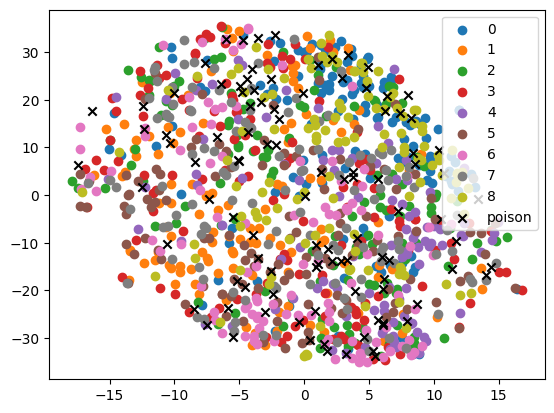

In [67]:
from sklearn.manifold import TSNE

def plot_features(model: nn.Module, dataloader: DataLoader, batches: int = None):
    model.eval()

    features = None
    labels_poison = None
    labels_true = None

    for i, (img, labels_batch_poison, labels_batch_true) in enumerate(dataloader):

        if batches is not None and i>=batches:
            break
    
        with torch.no_grad():
            features_batch = model(img.to(device)).cpu().data.numpy()
            
        if features is None:
            features = features_batch
            labels_poison = labels_batch_poison
            labels_true = labels_batch_true
        else:
            features = np.append(features, features_batch, axis=0)
            labels_poison = np.append(labels_poison, labels_batch_poison, axis=0)
            labels_true = np.append(labels_true, labels_batch_true, axis=0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    tsne_features = tsne.fit_transform(features)
    num_classes = max(labels_batch_poison)

    labels = labels_true
    labels[labels_true != labels_poison] = 10

    for i in range(num_classes):
        plt.scatter(tsne_features[labels==i,1], tsne_features[labels==i,0])
    plt.scatter(tsne_features[labels==10,1], tsne_features[labels==10,0], c = "black", marker= "x")

    plt.legend([str(i) for i in range(num_classes)] + ["poison"])
    plt.show()

    model.train()

plot_features(model, dataloader_no_contrastive, 10)

In [68]:
def train(dataloader, model, criterion, optimizer):
    loss_epoch = 0
    
    for step, (x_i, x_j) in enumerate(dataloader):
        optimizer.zero_grad()
        x_i = x_i.to(device).float()
        x_j = x_j.to(device).float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()
        
        if step % 50 == 0:
            print(f"\tStep [{step}/{len(dataloader)}]\t Loss: {round(loss.item(), 5)}")

        loss_epoch += loss.item()
    return loss_epoch / len(dataloader)

In [69]:
def save_model(model, optimizer, scheduler, epoch, name):
    out = os.path.join('./saved_models/', name)

    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'epoch': epoch
                }, out)

    print(f"\tSaved model, optimizer, scheduler and epoch info to {out}")

In [71]:
start_epoch = 151

load_checkpoint = True
checkpoint_name = "WaNet-SimCLR_150.pt"

if load_checkpoint:
    out = os.path.join('./saved_models/', checkpoint_name)
    checkpoint = torch.load(out, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    mainscheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    start_epoch = checkpoint["epoch"] + 1

Epoch [151/1000]	
	Step [0/391]	 Loss: 3.60523
	Step [50/391]	 Loss: 3.59582
	Step [100/391]	 Loss: 3.60494
	Step [150/391]	 Loss: 3.59401
	Step [200/391]	 Loss: 3.59992
	Step [250/391]	 Loss: 3.59464
	Step [300/391]	 Loss: 3.59458
	Step [350/391]	 Loss: 3.59918

	Training Loss: 3.5972740339196245
	Time Taken: 4.163252814610799 minutes
Epoch [152/1000]	
	Step [0/391]	 Loss: 3.59978
	Step [50/391]	 Loss: 3.59813
	Step [100/391]	 Loss: 3.60402
	Step [150/391]	 Loss: 3.5968
	Step [200/391]	 Loss: 3.60107
	Step [250/391]	 Loss: 3.60424
	Step [300/391]	 Loss: 3.596
	Step [350/391]	 Loss: 3.59808

	Training Loss: 3.5971882111581084
	Time Taken: 4.171785060564677 minutes
Epoch [153/1000]	
	Step [0/391]	 Loss: 3.59783
	Step [50/391]	 Loss: 3.59817
	Step [100/391]	 Loss: 3.59789
	Step [150/391]	 Loss: 3.59695
	Step [200/391]	 Loss: 3.60068
	Step [250/391]	 Loss: 3.59185
	Step [300/391]	 Loss: 3.5941
	Step [350/391]	 Loss: 3.60331

	Training Loss: 3.5971181221935145
	Time Taken: 4.11171354452769

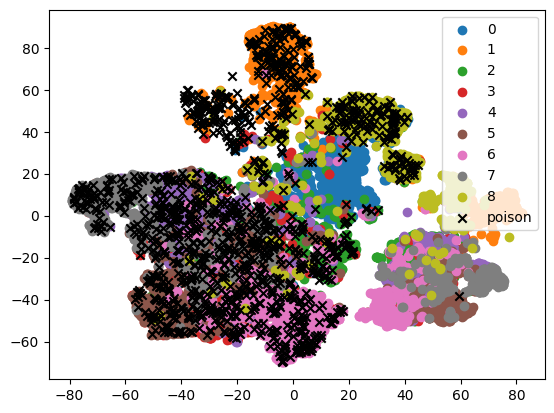

Epoch [161/1000]	
	Step [0/391]	 Loss: 3.60351
	Step [50/391]	 Loss: 3.59376
	Step [100/391]	 Loss: 3.59707
	Step [150/391]	 Loss: 3.59361
	Step [200/391]	 Loss: 3.59944
	Step [250/391]	 Loss: 3.59378
	Step [300/391]	 Loss: 3.593
	Step [350/391]	 Loss: 3.59639

	Training Loss: 3.596182824400685
	Time Taken: 4.09752311706543 minutes
Epoch [162/1000]	
	Step [0/391]	 Loss: 3.59475
	Step [50/391]	 Loss: 3.59402
	Step [100/391]	 Loss: 3.60056
	Step [150/391]	 Loss: 3.59783
	Step [200/391]	 Loss: 3.59591
	Step [250/391]	 Loss: 3.59726
	Step [300/391]	 Loss: 3.59688
	Step [350/391]	 Loss: 3.60157

	Training Loss: 3.5956494003305655
	Time Taken: 4.103339648246765 minutes
Epoch [163/1000]	
	Step [0/391]	 Loss: 3.59813
	Step [50/391]	 Loss: 3.60367
	Step [100/391]	 Loss: 3.59574
	Step [150/391]	 Loss: 3.59562
	Step [200/391]	 Loss: 3.59425
	Step [250/391]	 Loss: 3.59817
	Step [300/391]	 Loss: 3.59565
	Step [350/391]	 Loss: 3.59261

	Training Loss: 3.5955444510330627
	Time Taken: 4.10106262763341

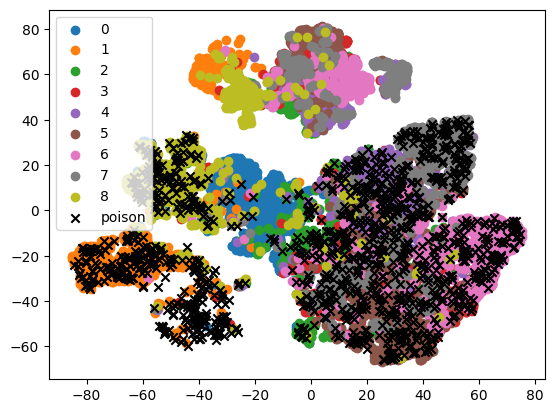

Epoch [171/1000]	
	Step [0/391]	 Loss: 3.59067
	Step [50/391]	 Loss: 3.5915
	Step [100/391]	 Loss: 3.59897
	Step [150/391]	 Loss: 3.59294
	Step [200/391]	 Loss: 3.60033
	Step [250/391]	 Loss: 3.59525
	Step [300/391]	 Loss: 3.59576
	Step [350/391]	 Loss: 3.59173

	Training Loss: 3.5945723819000945
	Time Taken: 4.119777484734853 minutes
Epoch [172/1000]	
	Step [0/391]	 Loss: 3.59512
	Step [50/391]	 Loss: 3.6002
	Step [100/391]	 Loss: 3.59149
	Step [150/391]	 Loss: 3.59759
	Step [200/391]	 Loss: 3.59796
	Step [250/391]	 Loss: 3.59834
	Step [300/391]	 Loss: 3.59238
	Step [350/391]	 Loss: 3.59999

	Training Loss: 3.5945302373003165
	Time Taken: 4.110247194766998 minutes
Epoch [173/1000]	
	Step [0/391]	 Loss: 3.59203
	Step [50/391]	 Loss: 3.59076
	Step [100/391]	 Loss: 3.59249
	Step [150/391]	 Loss: 3.60179
	Step [200/391]	 Loss: 3.59689
	Step [250/391]	 Loss: 3.59671
	Step [300/391]	 Loss: 3.59379
	Step [350/391]	 Loss: 3.59655

	Training Loss: 3.593993494882608
	Time Taken: 4.1082638581593

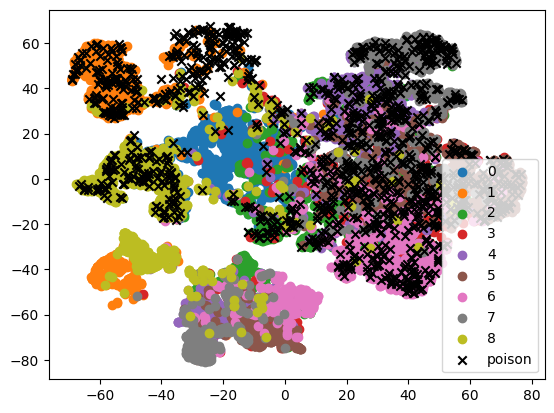

Epoch [181/1000]	
	Step [0/391]	 Loss: 3.59265
	Step [50/391]	 Loss: 3.59274
	Step [100/391]	 Loss: 3.59163
	Step [150/391]	 Loss: 3.59462
	Step [200/391]	 Loss: 3.59442
	Step [250/391]	 Loss: 3.59378
	Step [300/391]	 Loss: 3.59561
	Step [350/391]	 Loss: 3.5931

	Training Loss: 3.5933746712287062
	Time Taken: 4.103520850340526 minutes
Epoch [182/1000]	
	Step [0/391]	 Loss: 3.59259
	Step [50/391]	 Loss: 3.59145
	Step [100/391]	 Loss: 3.58832
	Step [150/391]	 Loss: 3.59845
	Step [200/391]	 Loss: 3.59295
	Step [250/391]	 Loss: 3.59422
	Step [300/391]	 Loss: 3.5974
	Step [350/391]	 Loss: 3.59545

	Training Loss: 3.5935832685826683
	Time Taken: 4.106237578392029 minutes
Epoch [183/1000]	
	Step [0/391]	 Loss: 3.59104
	Step [50/391]	 Loss: 3.59391
	Step [100/391]	 Loss: 3.59595
	Step [150/391]	 Loss: 3.60024
	Step [200/391]	 Loss: 3.5914
	Step [250/391]	 Loss: 3.59534
	Step [300/391]	 Loss: 3.59712
	Step [350/391]	 Loss: 3.60297

	Training Loss: 3.593273397601779
	Time Taken: 4.10475456714630

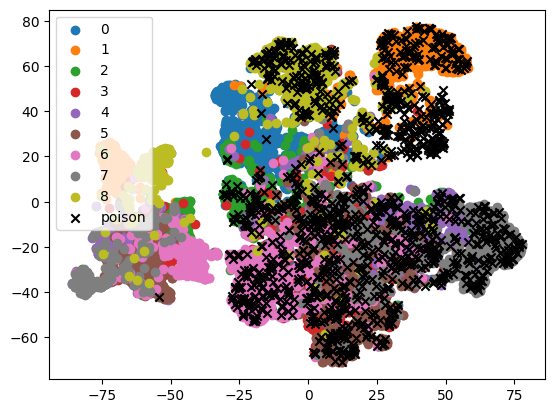

Epoch [191/1000]	
	Step [0/391]	 Loss: 3.59537
	Step [50/391]	 Loss: 3.59056
	Step [100/391]	 Loss: 3.58913
	Step [150/391]	 Loss: 3.59584
	Step [200/391]	 Loss: 3.59378
	Step [250/391]	 Loss: 3.59281
	Step [300/391]	 Loss: 3.59266
	Step [350/391]	 Loss: 3.59243

	Training Loss: 3.5926063079053483
	Time Taken: 4.103374660015106 minutes
Epoch [192/1000]	
	Step [0/391]	 Loss: 3.58978
	Step [50/391]	 Loss: 3.59576
	Step [100/391]	 Loss: 3.5965
	Step [150/391]	 Loss: 3.59025
	Step [200/391]	 Loss: 3.59923
	Step [250/391]	 Loss: 3.59424
	Step [300/391]	 Loss: 3.59117
	Step [350/391]	 Loss: 3.58911

	Training Loss: 3.5926584416948013
	Time Taken: 4.109875317414602 minutes
Epoch [193/1000]	
	Step [0/391]	 Loss: 3.59033
	Step [50/391]	 Loss: 3.60298
	Step [100/391]	 Loss: 3.59598
	Step [150/391]	 Loss: 3.59914
	Step [200/391]	 Loss: 3.59527
	Step [250/391]	 Loss: 3.59279
	Step [300/391]	 Loss: 3.59066
	Step [350/391]	 Loss: 3.59617

	Training Loss: 3.5926200221566593
	Time Taken: 4.11279228925

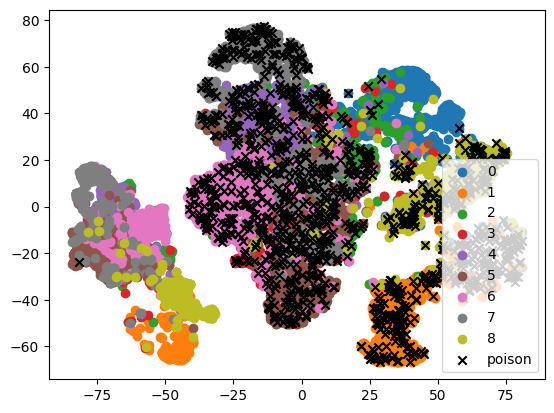

Epoch [201/1000]	
	Step [0/391]	 Loss: 3.58766
	Step [50/391]	 Loss: 3.58994
	Step [100/391]	 Loss: 3.59282
	Step [150/391]	 Loss: 3.58846
	Step [200/391]	 Loss: 3.59056
	Step [250/391]	 Loss: 3.59458
	Step [300/391]	 Loss: 3.59471
	Step [350/391]	 Loss: 3.59274

	Training Loss: 3.591464453036218
	Time Taken: 4.114776559670767 minutes
Epoch [202/1000]	
	Step [0/391]	 Loss: 3.58877
	Step [50/391]	 Loss: 3.59028
	Step [100/391]	 Loss: 3.60241
	Step [150/391]	 Loss: 3.59709
	Step [200/391]	 Loss: 3.59412
	Step [250/391]	 Loss: 3.59407
	Step [300/391]	 Loss: 3.58934
	Step [350/391]	 Loss: 3.58982

	Training Loss: 3.591363361119614
	Time Taken: 4.081660044193268 minutes
Epoch [203/1000]	
	Step [0/391]	 Loss: 3.59575
	Step [50/391]	 Loss: 3.5976
	Step [100/391]	 Loss: 3.59462
	Step [150/391]	 Loss: 3.58694
	Step [200/391]	 Loss: 3.59218
	Step [250/391]	 Loss: 3.59359
	Step [300/391]	 Loss: 3.59423
	Step [350/391]	 Loss: 3.59539

	Training Loss: 3.5913021399846774
	Time Taken: 4.0776434540748

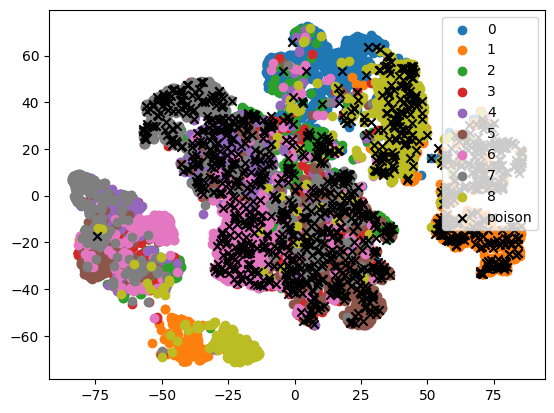

Epoch [211/1000]	
	Step [0/391]	 Loss: 3.59035
	Step [50/391]	 Loss: 3.59455
	Step [100/391]	 Loss: 3.59055
	Step [150/391]	 Loss: 3.58783
	Step [200/391]	 Loss: 3.59518
	Step [250/391]	 Loss: 3.59226
	Step [300/391]	 Loss: 3.58782
	Step [350/391]	 Loss: 3.59411

	Training Loss: 3.5907031715373554
	Time Taken: 4.091944201787313 minutes
Epoch [212/1000]	
	Step [0/391]	 Loss: 3.59183
	Step [50/391]	 Loss: 3.59042
	Step [100/391]	 Loss: 3.5932
	Step [150/391]	 Loss: 3.59213
	Step [200/391]	 Loss: 3.59182
	Step [250/391]	 Loss: 3.58766
	Step [300/391]	 Loss: 3.58618
	Step [350/391]	 Loss: 3.591

	Training Loss: 3.5904537643617984
	Time Taken: 4.0922944188117985 minutes
Epoch [213/1000]	
	Step [0/391]	 Loss: 3.5903
	Step [50/391]	 Loss: 3.58982
	Step [100/391]	 Loss: 3.59431
	Step [150/391]	 Loss: 3.59343
	Step [200/391]	 Loss: 3.58972
	Step [250/391]	 Loss: 3.58763
	Step [300/391]	 Loss: 3.5896
	Step [350/391]	 Loss: 3.59403

	Training Loss: 3.5908242314672836
	Time Taken: 4.08232005039850

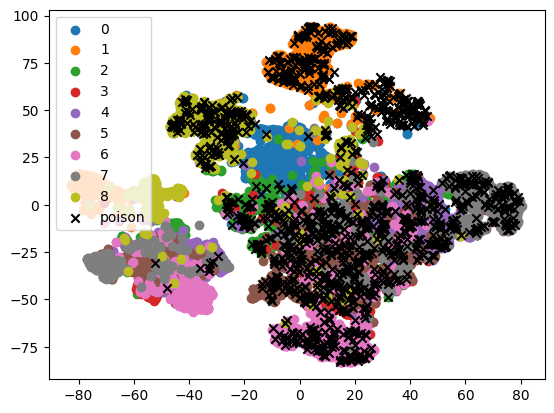

Epoch [221/1000]	
	Step [0/391]	 Loss: 3.58927
	Step [50/391]	 Loss: 3.59328
	Step [100/391]	 Loss: 3.58612
	Step [150/391]	 Loss: 3.59694
	Step [200/391]	 Loss: 3.59157
	Step [250/391]	 Loss: 3.58633
	Step [300/391]	 Loss: 3.59588
	Step [350/391]	 Loss: 3.58909

	Training Loss: 3.5897410251295474
	Time Taken: 4.0801612893740336 minutes
Epoch [222/1000]	
	Step [0/391]	 Loss: 3.59431
	Step [50/391]	 Loss: 3.59081
	Step [100/391]	 Loss: 3.59271
	Step [150/391]	 Loss: 3.59103
	Step [200/391]	 Loss: 3.59718
	Step [250/391]	 Loss: 3.58995
	Step [300/391]	 Loss: 3.58623
	Step [350/391]	 Loss: 3.59397

	Training Loss: 3.5896335898153007
	Time Taken: 4.093511275450388 minutes
Epoch [223/1000]	
	Step [0/391]	 Loss: 3.58979
	Step [50/391]	 Loss: 3.59175
	Step [100/391]	 Loss: 3.59493
	Step [150/391]	 Loss: 3.58884
	Step [200/391]	 Loss: 3.58843
	Step [250/391]	 Loss: 3.59659
	Step [300/391]	 Loss: 3.5984
	Step [350/391]	 Loss: 3.59127

	Training Loss: 3.5896341014091315
	Time Taken: 4.0960778594

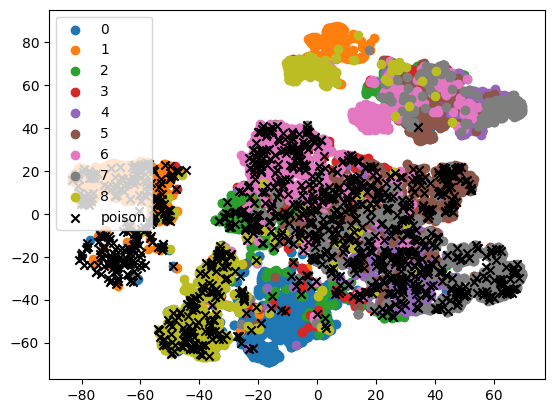

Epoch [231/1000]	
	Step [0/391]	 Loss: 3.59298
	Step [50/391]	 Loss: 3.59505
	Step [100/391]	 Loss: 3.59498
	Step [150/391]	 Loss: 3.5844
	Step [200/391]	 Loss: 3.58702
	Step [250/391]	 Loss: 3.58965
	Step [300/391]	 Loss: 3.59159
	Step [350/391]	 Loss: 3.58878

	Training Loss: 3.589160680161108
	Time Taken: 4.077211364110311 minutes
Epoch [232/1000]	
	Step [0/391]	 Loss: 3.59098
	Step [50/391]	 Loss: 3.59381
	Step [100/391]	 Loss: 3.59117
	Step [150/391]	 Loss: 3.58877
	Step [200/391]	 Loss: 3.58757
	Step [250/391]	 Loss: 3.58845
	Step [300/391]	 Loss: 3.5856
	Step [350/391]	 Loss: 3.58885

	Training Loss: 3.5885182951417423
	Time Taken: 4.069761308034261 minutes
Epoch [233/1000]	
	Step [0/391]	 Loss: 3.591
	Step [50/391]	 Loss: 3.58805
	Step [100/391]	 Loss: 3.58905
	Step [150/391]	 Loss: 3.59164
	Step [200/391]	 Loss: 3.58495
	Step [250/391]	 Loss: 3.58923
	Step [300/391]	 Loss: 3.58726
	Step [350/391]	 Loss: 3.59297

	Training Loss: 3.58890085147165
	Time Taken: 4.081711332003276 m

KeyboardInterrupt: 

In [72]:
losses = []

for epoch in range(start_epoch, epochs+1):
    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    model.train()
    loss = train(dataloader, model, criterion, optimizer)
    losses.append(loss)

    if epoch <= 10:
        warmupscheduler.step()
    if epoch > 10:
        mainscheduler.step()
    
    print()
    print(f"\tTraining Loss: {loss}")
    time_taken = (time.time()-stime)/60
    print(f"\tTime Taken: {time_taken} minutes")

    if (epoch) % 10 == 0:
        save_model(model, optimizer, mainscheduler, epoch, f"SimCLR_{epoch}.pt")
        plot_features(model, dataloader_no_contrastive, 100)

## end training
save_model(model, optimizer, mainscheduler, epochs, f"SimCLR_{epochs}.pt")